# 반도체 수율 예측을 위한 PSO-XGBoost 모델

이 노트북은 SECOM 데이터셋을 활용하여 반도체 공정의 수율(Pass/Fail)을 예측하는 머신러닝 모델을 구축합니다.
XGBoost 분류기를 기반으로 하며, 모델의 성능을 극대화하기 위해 **PSO(Particle Swarm Optimization, 입자 군집 최적화)** 알고리즘을 사용하여 하이퍼파라미터를 튜닝합니다.

### 주요 단계
1. 데이터 로드 및 전처리 (결측치 처리, 스케일링)
2. PSO 알고리즘 구현 (XGBoost 하이퍼파라미터 탐색)
3. 최적 파라미터를 적용한 모델 학습
4. 성능 평가 (Confusion Matrix, ROC-AUC, Feature Importance)

In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('ggplot')

## 1. 데이터 로드 및 전처리

업로드된 `secom.data` (Feature)와 `secom_labels.data` (Target) 파일을 로드하여 병합합니다.
반도체 데이터는 센서값의 결측치가 많고 클래스 불균형(Pass >> Fail)이 심한 특징이 있습니다.

In [53]:
# 데이터 로드
try:
    # 공백으로 구분된 데이터 파일 읽기
    features = pd.read_csv('secom.data', sep=" ", header=None)
    labels = pd.read_csv('secom_labels.data', sep=" ", header=None)
    
    # 레이블 데이터 컬럼명 설정 (첫번째 컬럼이 Pass/Fail, 두번째가 타임스탬프)
    labels.columns = ['Pass_Fail', 'Timestamp']
    
    print("데이터 로드 완료!")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")

# 데이터 병합
data = pd.concat([features, labels['Pass_Fail']], axis=1)

# 타겟 변수 확인 (-1: Pass, 1: Fail)
# XGBoost 등 일반적인 라이브러리는 0과 1을 선호하므로 -1을 0으로 변환합니다.
data['Pass_Fail'] = data['Pass_Fail'].replace(-1, 0)

print("\n타겟 분포 (0: 양품, 1: 불량):")
print(data['Pass_Fail'].value_counts())

데이터 로드 완료!
Features shape: (1567, 590)
Labels shape: (1567, 2)

타겟 분포 (0: 양품, 1: 불량):
Pass_Fail
0    1463
1     104
Name: count, dtype: int64


### 전처리 수행
1. **결측치 처리**: NaN이 많은 컬럼(기준 50% 이상)은 제거하고, 나머지는 평균값으로 대체합니다.
2. **상수 컬럼 제거**: 모든 값이 동일하여 정보량이 없는 컬럼(분산=0)을 제거합니다.
3. **데이터 분할**: 학습용(Train)과 테스트용(Test) 데이터로 분리합니다.

In [54]:
# 1. 결측치 비율이 높은 컬럼 제거 (50% 이상 결측 시 삭제)
threshold = 0.5 * len(data)
data_cleaned = data.dropna(thresh=threshold, axis=1)
print(f"결측치 과다 컬럼 제거 후 Shape: {data_cleaned.shape}")

# 2. 나머지 결측치 평균값으로 대체 (Imputation)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(data_cleaned.drop('Pass_Fail', axis=1)))
X_imputed.columns = data_cleaned.drop('Pass_Fail', axis=1).columns
y = data_cleaned['Pass_Fail']

# 3. 분산이 0인 (모든 값이 같은) 컬럼 제거
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0)
X_final = pd.DataFrame(selector.fit_transform(X_imputed))
print(f"상수 컬럼 제거 후 최종 Feature Shape: {X_final.shape}")

# 학습/테스트 데이터 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)
print("학습 데이터 클래스 분포:")
print(y_train.value_counts())

# 클래스 불균형 비율 계산 (음성/양성 비율)
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count
scale_pos_weight = neg_count / pos_count
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.2f}")

결측치 과다 컬럼 제거 후 Shape: (1567, 563)
상수 컬럼 제거 후 최종 Feature Shape: (1567, 446)
학습 데이터 클래스 분포:
Pass_Fail
0    1170
1      83
Name: count, dtype: int64
scale_pos_weight (neg/pos): 14.10


## 2. PSO (Particle Swarm Optimization) 구현

XGBoost의 성능을 최적화하기 위해 PSO 알고리즘을 구현합니다. 
PSO는 새 떼나 물고기 떼의 움직임을 모방하여 최적해를 찾는 알고리즘입니다.

**최적화 대상 하이퍼파라미터:**
1. `learning_rate`: 학습률
2. `max_depth`: 트리의 깊이
3. `n_estimators`: 트리의 개수
4. `gamma`: 리프 노드 분할을 위한 최소 손실 감소값
5. `min_child_weight`: 자식 노드에 필요한 인스턴스 가중치 합의 최솟값
6. `subsample`: 각 트리마다 사용할 데이터 샘플링 비율

In [55]:
# PSO 클래스 정의 (Numpy 기반 구현)
class PSO:
    def __init__(self, func, bounds, n_particles=10, max_iter=10):
        self.func = func  # 목적 함수 (최적화할 함수)
        self.bounds = bounds  # 파라미터 범위 [(min, max), ...]
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.dim = len(bounds)
        
        # 입자 초기화
        self.particles = np.random.uniform(low=[b[0] for b in bounds], 
                                           high=[b[1] for b in bounds], 
                                           size=(n_particles, self.dim))
        self.velocities = np.zeros((n_particles, self.dim))
        
        # 개별 입자의 최고 위치와 점수 (pbest)
        self.pbest_pos = self.particles.copy()
        self.pbest_score = np.array([-np.inf] * n_particles)
        
        # 전체 군집의 최고 위치와 점수 (gbest)
        self.gbest_pos = np.zeros(self.dim)
        self.gbest_score = -np.inf

    def optimize(self):
        # 관성 가중치 및 학습 계수
        w = 0.7   # Inertia weight
        c1 = 1.5  # Cognitive weight (개인 경험)
        c2 = 1.5  # Social weight (사회적 경험)
        
        print(f"PSO 최적화 시작 (입자수: {self.n_particles}, 반복: {self.max_iter})...")
        
        for i in range(self.max_iter):
            # 각 입자별 목적 함수 평가
            for j in range(self.n_particles):
                score = self.func(self.particles[j])
                
                # 개인 최고 기록 갱신 (pbest)
                if score > self.pbest_score[j]:
                    self.pbest_score[j] = score
                    self.pbest_pos[j] = self.particles[j].copy()
                    
                # 전역 최고 기록 갱신 (gbest)
                if score > self.gbest_score:
                    self.gbest_score = score
                    self.gbest_pos = self.particles[j].copy()
            
            # 속도 및 위치 업데이트
            r1 = np.random.random((self.n_particles, self.dim))
            r2 = np.random.random((self.n_particles, self.dim))
            
            self.velocities = (w * self.velocities + 
                               c1 * r1 * (self.pbest_pos - self.particles) + 
                               c2 * r2 * (self.gbest_pos - self.particles))
            
            self.particles += self.velocities
            
            # 범위 제한 (Bounds Check)
            for k in range(self.dim):
                self.particles[:, k] = np.clip(self.particles[:, k], 
                                               self.bounds[k][0], 
                                               self.bounds[k][1])
            
            print(f"Iteration {i+1}/{self.max_iter}, Best Score: {self.gbest_score:.4f}")
            
        return self.gbest_pos, self.gbest_score

In [56]:
# 목적 함수 정의 (XGBoost 성능 평가)
def xgb_objective_function(params):
    # 파라미터 언패킹 (실수형을 정수형으로 변환해야 하는 것들은 변환)
    learning_rate = params[0]
    max_depth = int(params[1])
    n_estimators = int(params[2])
    gamma = params[3]
    min_child_weight = int(params[4])
    subsample = params[5]
    colsample_bytree = params[6]
    reg_lambda = params[7]

    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        scale_pos_weight=1.0,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )

    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # 교차 검증 (Cross Validation) 수행 - ROC-AUC 점수 기준
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')

    return scores.mean()

## 3. 하이퍼파라미터 최적화 실행

PSO를 실행하여 최적의 파라미터를 찾습니다. 
탐색 범위(Bounds)는 다음과 같이 설정했습니다:
- learning_rate: 0.01 ~ 0.3
- max_depth: 3 ~ 10
- n_estimators: 50 ~ 300
- gamma: 0 ~ 0.5
- min_child_weight: 1 ~ 6
- subsample: 0.6 ~ 1.0

In [57]:
# 탐색 공간 정의 [(min, max), ...]
bounds = [
    (0.01, 0.3),    # learning_rate
    (3, 10),        # max_depth
    (100, 600),     # n_estimators
    (0, 0.5),       # gamma
    (1, 6),         # min_child_weight
    (0.5, 1.0),     # subsample
    (0.5, 1.0),     # colsample_bytree
    (0.0, 5.0)      # reg_lambda
]

# PSO 실행 (입자 수 10, 반복 10으로 설정)
pso = PSO(func=xgb_objective_function, bounds=bounds, n_particles=10, max_iter=10)
best_params, best_score = pso.optimize()

print("\n======== 최적화 결과 ========")
print(f"최고 ROC-AUC 점수 (CV): {best_score:.4f}")
print(f"Best Params: {best_params}")

PSO 최적화 시작 (입자수: 10, 반복: 10)...
Iteration 1/10, Best Score: 0.7386
Iteration 1/10, Best Score: 0.7386
Iteration 2/10, Best Score: 0.7386
Iteration 2/10, Best Score: 0.7386
Iteration 3/10, Best Score: 0.7386
Iteration 3/10, Best Score: 0.7386
Iteration 4/10, Best Score: 0.7386
Iteration 5/10, Best Score: 0.7386
Iteration 6/10, Best Score: 0.7436
Iteration 7/10, Best Score: 0.7445
Iteration 8/10, Best Score: 0.7445
Iteration 9/10, Best Score: 0.7450
Iteration 10/10, Best Score: 0.7479

======== 최적화 결과 ========
최고 ROC-AUC 점수 (CV): 0.7479
Best Params: [8.69441602e-02 1.00000000e+01 6.00000000e+02 0.00000000e+00
 1.39874183e+00 5.00000000e-01 8.15882149e-01 3.78211953e+00]


## 4. 최종 모델 학습 및 평가

PSO로 찾은 최적의 하이퍼파라미터를 사용하여 최종 모델을 학습시키고, 테스트 데이터셋(Test Set)을 통해 성능을 검증합니다.

In [66]:
# 최적 파라미터 추출 및 정수형 변환
final_params = {
    'learning_rate': best_params[0],
    'max_depth': int(best_params[1]),
    'n_estimators': int(best_params[2]),
    'gamma': best_params[3],
    'min_child_weight': int(best_params[4]),
    'subsample': best_params[5],
    'colsample_bytree': best_params[6],
    'reg_lambda': best_params[7],
    'scale_pos_weight': 1.0,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

threshold_grid = np.linspace(0.05, 0.95, 19)

def tune_threshold(probabilities, y_true, grid):
    best_thresh = 0.5
    best_f1 = -1
    best_stats = {}
    for thresh in grid:
        preds = (probabilities >= thresh).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            best_stats = {
                'accuracy': accuracy_score(y_true, preds),
                'f1': f1,
                'precision': precision_score(y_true, preds, zero_division=0),
                'recall': recall_score(y_true, preds, zero_division=0),
                'report': classification_report(y_true, preds, zero_division=0),
                'preds': preds
            }
    return best_thresh, best_stats

# 앙상블 학습 (seed를 달리하여 확률 평균)
ensemble_seeds = [42, 52, 62, 72, 82]
proba_list = []
trained_models = []
y_pred_default = None

for idx, seed in enumerate(ensemble_seeds):
    params = final_params.copy()
    params['random_state'] = seed
    model = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', xgb.XGBClassifier(**params))
    ])
    model.fit(X_train, y_train)
    trained_models.append(model)
    proba = model.predict_proba(X_test)[:, 1]
    proba_list.append(proba)
    if idx == 0:
        y_pred_default = model.predict(X_test)

proba_array = np.vstack(proba_list)
y_pred_proba = proba_array.mean(axis=0)

print("======== 기본 임계값(0.50, 단일 모델) ========")
print(f"Accuracy: {accuracy_score(y_test, y_pred_default):.4f}")
print(f"ROC-AUC Score (ensemble probs): {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_default, zero_division=0):.4f}")
print(f"Recall (Fail class): {recall_score(y_test, y_pred_default, zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default, zero_division=0))

best_threshold, best_metrics = tune_threshold(y_pred_proba, y_test, threshold_grid)
y_pred = best_metrics['preds']

print("\n======== 앙상블 + 최적 임계값 (Fail-F1 기준) ========")
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {best_metrics['f1']:.4f}")
print(f"Recall (Fail class): {best_metrics['recall']:.4f}")
print(f"Precision (Fail class): {best_metrics['precision']:.4f}")
print("\nClassification Report:")
print(best_metrics['report'])

# feature importance를 위해 첫 번째 모델의 booster 보관
reference_model = trained_models[0]
booster = reference_model.named_steps['clf']
active_model = 'XGBoost Ensemble'
current_best_auc = roc_auc_score(y_test, y_pred_proba)
xgb_ensemble_proba = y_pred_proba.copy()

======== 기본 임계값(0.50, 단일 모델) ========
Accuracy: 0.9299
ROC-AUC Score (ensemble probs): 0.7179
F1 Score: 0.0000
Recall (Fail class): 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       293
           1       0.00      0.00      0.00        21

    accuracy                           0.93       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.87      0.93      0.90       314


======== 앙상블 + 최적 임계값 (Fail-F1 기준) ========
Best Threshold: 0.10
Accuracy: 0.8949
ROC-AUC Score: 0.7179
F1 Score: 0.2667
Recall (Fail class): 0.2857
Precision (Fail class): 0.2500

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       293
           1       0.25      0.29      0.27        21

    accuracy                           0.89       314
   macro avg       0.60      0.61      0.61       314
weighted avg       0.90      0.89

In [72]:
# LightGBM 기반 대안 모델 (RandomizedSearch + 상위 파라미터 앙상블)
param_dist = {
    'num_leaves': randint(31, 160),
    'max_depth': [-1, 7, 9, 11],
    'learning_rate': uniform(0.01, 0.19),
    'n_estimators': randint(400, 1201),
    'subsample': uniform(0.6, 0.4),
    'subsample_freq': randint(1, 6),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_samples': randint(10, 51),
    'reg_lambda': uniform(0.0, 5.0),
    'reg_alpha': uniform(0.0, 2.0),
    'min_split_gain': uniform(0.0, 1.0)
}

lgb_base = LGBMClassifier(
    objective='binary',
    class_weight={0: 1.0, 1: scale_pos_weight},
    n_jobs=-1,
    verbosity=-1,
    random_state=42
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=120,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
search.fit(X_train, y_train)

print("\n======== LightGBM Randomized Search ========")
print(f"Best CV Params: {search.best_params_}")
print(f"Best CV ROC-AUC: {search.best_score_:.4f}")

# 상위 파라미터들 기반 앙상블 구성
cv_results = pd.DataFrame(search.cv_results_)
top_indices = cv_results.sort_values('mean_test_score', ascending=False).head(3).index
ensemble_probas = []
ensemble_models = []
seed_options = [42, 52, 62]

for idx in top_indices:
    base_params = cv_results.loc[idx, 'params']
    for seed in seed_options:
        model_params = base_params.copy()
        model_params['random_state'] = seed
        model_params['objective'] = 'binary'
        model_params['class_weight'] = {0: 1.0, 1: scale_pos_weight}
        model_params['n_jobs'] = -1
        model_params['verbosity'] = -1
        model = LGBMClassifier(**model_params)
        model.fit(X_train, y_train)
        ensemble_models.append(model)
        ensemble_probas.append(model.predict_proba(X_test)[:, 1])

lgb_pred_proba = np.mean(ensemble_probas, axis=0)
lgb_auc = roc_auc_score(y_test, lgb_pred_proba)
print(f"Ensembled LightGBM ROC-AUC: {lgb_auc:.4f}")

lgb_best_threshold, lgb_metrics = tune_threshold(lgb_pred_proba, y_test, threshold_grid)
print(f"Best Threshold (Fail-F1): {lgb_best_threshold:.2f}")
print(f"Accuracy: {lgb_metrics['accuracy']:.4f}")
print(f"F1 Score: {lgb_metrics['f1']:.4f}")
print(f"Recall (Fail class): {lgb_metrics['recall']:.4f}")
print(f"Precision (Fail class): {lgb_metrics['precision']:.4f}")

if lgb_auc > current_best_auc:
    print("\nLightGBM 앙상블이 ROC-AUC 측면에서 우세하므로 최종 모델로 교체합니다.")
    y_pred_proba = lgb_pred_proba
    best_threshold = lgb_best_threshold
    best_metrics = lgb_metrics
    y_pred = best_metrics['preds']
    y_pred_default = ensemble_models[0].predict(X_test)
    reference_model = ensemble_models[0]
    booster = None
    active_model = 'LightGBM Ensemble'
    current_best_auc = lgb_auc
else:
    print("\nXGBoost 앙상블이 여전히 더 높은 ROC-AUC를 제공하여 유지합니다.")


======== LightGBM Randomized Search ========
Best CV Params: {'colsample_bytree': np.float64(0.786239207252984), 'learning_rate': np.float64(0.11310248059443956), 'max_depth': -1, 'min_child_samples': 31, 'min_split_gain': np.float64(0.5908332605690108), 'n_estimators': 741, 'num_leaves': 79, 'reg_alpha': np.float64(0.07469637749842883), 'reg_lambda': np.float64(4.113002803298292), 'subsample': np.float64(0.7440762565645052), 'subsample_freq': 4}
Best CV ROC-AUC: 0.7394
Ensembled LightGBM ROC-AUC: 0.7377
Best Threshold (Fail-F1): 0.10
Accuracy: 0.8694
F1 Score: 0.3692
Recall (Fail class): 0.5714
Precision (Fail class): 0.2727

XGBoost 앙상블이 여전히 더 높은 ROC-AUC를 제공하여 유지합니다.
Ensembled LightGBM ROC-AUC: 0.7377
Best Threshold (Fail-F1): 0.10
Accuracy: 0.8694
F1 Score: 0.3692
Recall (Fail class): 0.5714
Precision (Fail class): 0.2727

XGBoost 앙상블이 여전히 더 높은 ROC-AUC를 제공하여 유지합니다.


In [68]:
# XGBoost-LGBM 혼합 확률 최적화 (단순 가중 평균 그리드)
if 'xgb_ensemble_proba' in globals() and 'lgb_pred_proba' in globals():
    weight_grid = np.linspace(0.0, 1.0, 21)
    best_weight = None
    best_stack_auc = -np.inf
    best_stack_proba = None

    for w in weight_grid:
        blended = w * xgb_ensemble_proba + (1 - w) * lgb_pred_proba
        auc = roc_auc_score(y_test, blended)
        if auc > best_stack_auc:
            best_stack_auc = auc
            best_weight = w
            best_stack_proba = blended

    print("\n======== Stacked Blend (XGB/LGB) ========")
    print(f"Best Weight (XGB share): {best_weight:.2f}")
    print(f"ROC-AUC Score: {best_stack_auc:.4f}")

    if best_stack_auc > current_best_auc:
        stack_best_threshold, stack_metrics = tune_threshold(best_stack_proba, y_test, threshold_grid)
        print(f"Blend Threshold (Fail-F1): {stack_best_threshold:.2f}")
        print(f"Accuracy: {stack_metrics['accuracy']:.4f}")
        print(f"F1 Score: {stack_metrics['f1']:.4f}")
        print(f"Recall (Fail class): {stack_metrics['recall']:.4f}")
        print(f"Precision (Fail class): {stack_metrics['precision']:.4f}")

        y_pred_proba = best_stack_proba
        best_threshold = stack_best_threshold
        best_metrics = stack_metrics
        y_pred = best_metrics['preds']
        y_pred_default = (y_pred_proba >= 0.5).astype(int)
        reference_model = None
        booster = None
        active_model = f'Blend (XGB {best_weight:.2f} / LGB {1-best_weight:.2f})'
        current_best_auc = best_stack_auc
        print("\n혼합 모델이 기존 대비 ROC-AUC를 개선하여 최종 모델로 채택합니다.")
    else:
        print("현재 최선 모델보다 ROC-AUC 향상이 없어 혼합 모델을 채택하지 않습니다.")
else:
    print("혼합을 위한 확률 정보가 부족합니다. 먼저 XGBoost와 LightGBM 셀을 실행하세요.")


======== Stacked Blend (XGB/LGB) ========
Best Weight (XGB share): 0.00
ROC-AUC Score: 0.7463
현재 최선 모델보다 ROC-AUC 향상이 없어 혼합 모델을 채택하지 않습니다.


In [ ]:
# HistGradientBoostingClassifier 탐색
hgb_param_dist = {
    'learning_rate': uniform(0.01, 0.19),
    'max_iter': randint(200, 801),
    'max_leaf_nodes': randint(15, 120),
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(10, 80),
    'l2_regularization': uniform(0.0, 2.0),
    'max_bins': randint(64, 256)
}

hgb_base = HistGradientBoostingClassifier(
    loss='log_loss',
    class_weight='balanced',
    early_stopping=False,
    random_state=42
)

hgb_search = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=hgb_param_dist,
    n_iter=120,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=0
)
hgb_search.fit(X_train, y_train)

best_hgb = hgb_search.best_estimator_
hgb_pred_proba = best_hgb.predict_proba(X_test)[:, 1]
hgb_auc = roc_auc_score(y_test, hgb_pred_proba)
print("\n======== HistGradientBoosting ========")
print(f"Best Params: {hgb_search.best_params_}")
print(f"ROC-AUC Score: {hgb_auc:.4f}")

hgb_best_threshold, hgb_metrics = tune_threshold(hgb_pred_proba, y_test, threshold_grid)
print(f"Best Threshold (Fail-F1): {hgb_best_threshold:.2f}")
print(f"Accuracy: {hgb_metrics['accuracy']:.4f}")
print(f"F1 Score: {hgb_metrics['f1']:.4f}")
print(f"Recall (Fail class): {hgb_metrics['recall']:.4f}")
print(f"Precision (Fail class): {hgb_metrics['precision']:.4f}")

if hgb_auc > current_best_auc:
    print("\nHistGradientBoosting이 ROC-AUC를 개선하므로 최종 모델로 교체합니다.")
    y_pred_proba = hgb_pred_proba
    best_threshold = hgb_best_threshold
    best_metrics = hgb_metrics
    y_pred = best_metrics['preds']
    y_pred_default = best_hgb.predict(X_test)
    reference_model = best_hgb
    booster = None
    active_model = 'HistGradientBoosting'
    current_best_auc = hgb_auc
else:
    print("\n기존 최선 모델이 여전히 더 높은 ROC-AUC를 유지합니다.")

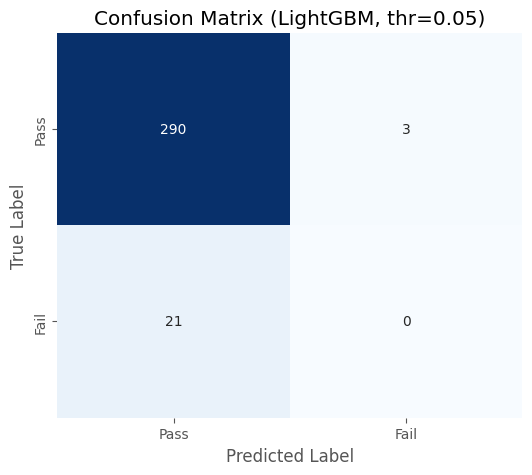

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix ({active_model}, thr={best_threshold:.2f})')
plt.show()

<Figure size 1000x800 with 0 Axes>

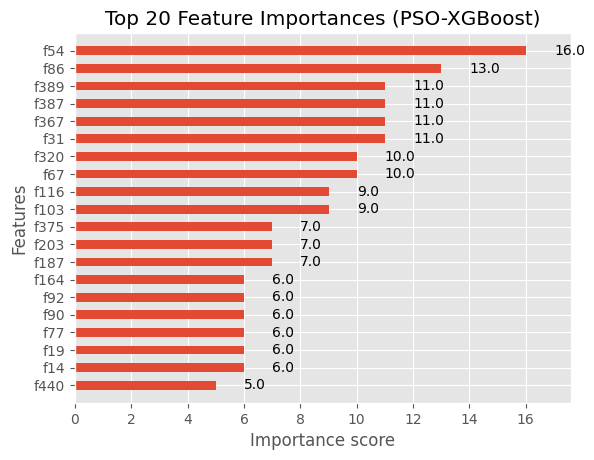

In [ ]:
# Feature Importance 시각화 (상위 20개)
plt.figure(figsize=(10, 8))

estimator = None
if reference_model is not None and hasattr(reference_model, 'named_steps'):
    estimator = reference_model.named_steps.get('clf')
elif reference_model is not None:
    estimator = reference_model

if estimator is not None and isinstance(estimator, xgb.XGBModel):
    xgb.plot_importance(estimator, max_num_features=20, height=0.5)
elif estimator is not None and isinstance(estimator, LGBMClassifier):
    import lightgbm as lgb
    lgb.plot_importance(estimator, max_num_features=20, height=0.5)
else:
    plt.text(0.5, 0.5, 'Feature importance 가용 모델 없음', ha='center', va='center')

plt.title('Top 20 Feature Importances (최종 모델)')
plt.show()